In [66]:
import pymupdf

In [67]:
file_example = "../data/vestibular/provas/prova_ita_vestibular_2025_prova_1f.pdf"

In [68]:
doc = pymupdf.open(file_example)

In [69]:
out = open("output.txt", "wb")
for page in doc:
  text = page.get_text().encode("utf8")
  out.write(text)
  out.write(bytes((12,)))
out.close()

In [70]:
# Encontrar posições (4 cantos) de cada "Questão N." no PDF
# Regra: todas as questões começam com o texto "Questão".
# Exceção: redação não começa com "Questão" e normalmente está em página separada.
from pathlib import Path
import re

# Número máximo de questões a buscar (prova ITA pode ter 48+ questões; ajuste se precisar)
MAX_QUESTIONS = 60
# Margens opcionais (pixels) para o recorte
MARGIN_LEFT = 0
MARGIN_TOP_BOTTOM = 8

# Variações do texto no PDF (ponto, dois-pontos, espaço; às vezes o ponto falha).
# Em alguns PDFs "Questão" aparece como "Quest" + U+02DC (˜) + "ao" em vez de "ã" (acento).
QUESTAO_QUEBRADO = "Quest" + "\u02dc" + "ao"  # tilde separado: Quest˜ao


def _needles_for_question(n):
  return [
    f"Questão {n}.",
    f"Questão {n}",
    f"Questão {n}:",
    f"Questão {n} .",
    f"{QUESTAO_QUEBRADO} {n}.",
    f"{QUESTAO_QUEBRADO} {n}",
    f"{QUESTAO_QUEBRADO} {n}:",
    f"Questao {n}.",
    f"Questao {n}",
  ]


def _linha_eh_inicio_questao(line_strip, n):
  """True se a linha começa com 'Questão N' ou variantes (Questao, Quest˜ao)."""
  if not line_strip:
    return False
  # Normalizar: tratar Questão, Questao, Quest˜ao (U+02DC) como equivalente
  normal = line_strip.replace("Questão", "Questao").replace(QUESTAO_QUEBRADO, "Questao")
  return (
    re.match(rf"^Questao\s+{n}\s*[.:]?\s", normal)
    or re.match(rf"^Questao\s+{n}\s*[.:]?$", normal)
    or normal.startswith(f"Questao {n}.")
    or normal.startswith(f"Questao {n}:")
  )


def _find_question_in_page_dict(page, n):
  """Fallback: procura início de linha 'Questão N' no texto da página (get_text dict) e retorna rect ou None."""
  d = page.get_text("dict", clip=page.rect)
  for block in d.get("blocks", []):
    for line in block.get("lines", []):
      line_text = "".join(s.get("text", "") for s in line.get("spans", []))
      line_strip = line_text.strip()
      if _linha_eh_inicio_questao(line_strip, n):
        bbox = line.get("bbox")
        if bbox:
          return pymupdf.Rect(bbox)
  return None


def find_question_positions(doc, max_questions=MAX_QUESTIONS):
  """Retorna lista de (num_questão, page_no, rect_início).
  Tenta várias formas de 'Questão N'; se não achar, usa fallback por get_text(dict).
  """
  positions = []
  found_numbers = set()
  for page_no in range(len(doc)):
    page = doc[page_no]
    for n in range(1, max_questions + 1):
      if n in found_numbers:
        continue
      rect = None
      for needle in _needles_for_question(n):
        rects = page.search_for(needle)
        if rects:
          rect = rects[0]
          break
      if rect is None:
        rect = _find_question_in_page_dict(page, n)
      if rect is not None:
        positions.append((n, page_no, rect))
        found_numbers.add(n)
  # Ordenar por página e depois por y
  positions.sort(key=lambda x: (x[1], x[2].y0))
  return positions


positions = find_question_positions(doc)
encontrados = {p[0] for p in positions}
puladas = [n for n in range(1, MAX_QUESTIONS + 1) if n not in encontrados]
print(f"Encontradas {len(positions)} posições de início de questão.")
if puladas:
  print(
    f"  Atenção: questões não encontradas (podem ter formato diferente ou estar em outra prova): {puladas}"
  )
for p in positions[:10]:
  print(
    f"  Questão {p[0]} na página {p[1]}: bbox = ({p[2].x0:.1f}, {p[2].y0:.1f}, {p[2].x1:.1f}, {p[2].y1:.1f})"
  )

Encontradas 48 posições de início de questão.
  Atenção: questões não encontradas (podem ter formato diferente ou estar em outra prova): [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
  Questão 1 na página 1: bbox = (56.7, 259.4, 118.5, 271.4)
  Questão 2 na página 1: bbox = (56.7, 348.2, 117.8, 360.2)
  Questão 3 na página 1: bbox = (56.7, 515.2, 117.8, 527.1)
  Questão 4 na página 1: bbox = (56.7, 571.0, 117.5, 582.9)
  Questão 5 na página 2: bbox = (56.7, 59.5, 117.8, 71.4)
  Questão 6 na página 2: bbox = (56.7, 289.1, 117.8, 301.1)
  Questão 7 na página 2: bbox = (56.7, 390.2, 117.8, 402.1)
  Questão 8 na página 2: bbox = (56.7, 545.0, 117.8, 557.0)
  Questão 9 na página 3: bbox = (56.7, 59.5, 118.6, 71.4)
  Questão 10 na página 3: bbox = (56.7, 177.1, 124.5, 189.1)


In [71]:
# Definir retângulo (4 cantos) de cada questão: do início de "Questão N." até o início de "Questão N+1."
# Refinamento: se houver itens objetivos (A a E) no clip, terminar o recorte no fim do bloco de itens,
# para não incluir texto que vem logo abaixo (ex.: "Leia o texto a seguir para as questões 43 e 44").
# Usamos os 5 itens (A,B,C,D,E) para achar o fim do bloco, não só E, assim funciona em qualquer layout.


def _fim_bloco_itens_objetivos(page, clip, margin=4):
  """Retorna o y1 do fim do bloco de itens A–E dentro do clip, ou None."""
  rects = []
  for letra in ("A", "B", "C", "D", "E"):
    rects.extend(page.search_for(f"{letra} (", clip=clip))
    rects.extend(page.search_for(f"{letra} ( )", clip=clip))
  if not rects:
    return None
  return max(r.y1 for r in rects) + margin


def _refinar_clip_ate_fim_itens(page, clip):
  """Se achar itens A–E no clip, limita o clip até o fim desse bloco (exclui texto abaixo)."""
  y1_itens = _fim_bloco_itens_objetivos(page, clip)
  if y1_itens is None or y1_itens >= clip.y1:
    return clip
  return pymupdf.Rect(clip.x0, clip.y0, clip.x1, y1_itens)


def build_question_rectangles(doc, positions):
  x0_page = doc[0].rect.x0 + MARGIN_LEFT
  x1_page = doc[0].rect.x1
  questions = {}
  for i, (num, page_no, rect) in enumerate(positions):
    start_page = page_no
    start_y = rect.y0 - MARGIN_TOP_BOTTOM
    if i + 1 < len(positions):
      next_num, next_page, next_rect = positions[i + 1]
      end_page = next_page
      end_y = next_rect.y0 - MARGIN_TOP_BOTTOM
    else:
      end_page = start_page
      end_y = doc[start_page].rect.y1
    if start_page == end_page:
      clip = pymupdf.Rect(x0_page, start_y, x1_page, end_y)
      clip = _refinar_clip_ate_fim_itens(doc[start_page], clip)
      questions[num] = [(start_page, clip)]
    else:
      questions[num] = []
      pr = doc[start_page].rect
      questions[num].append(
        (start_page, pymupdf.Rect(x0_page, start_y, x1_page, pr.y1))
      )
      for p in range(start_page + 1, end_page):
        pr = doc[p].rect
        questions[num].append((p, pymupdf.Rect(x0_page, pr.y0, x1_page, pr.y1)))
      pr = doc[end_page].rect
      clip_last = pymupdf.Rect(x0_page, pr.y0, x1_page, end_y)
      clip_last = _refinar_clip_ate_fim_itens(doc[end_page], clip_last)
      questions[num].append((end_page, clip_last))
  return questions


question_rects = build_question_rectangles(doc, positions)
print(f"Definidos retângulos para {len(question_rects)} questões.")
# Avisar quando há lacuna: a "próxima" questão não é N+1 (recorte da atual fica até a próxima encontrada)
for i in range(len(positions) - 1):
  num, next_num = positions[i][0], positions[i + 1][0]
  if next_num != num + 1:
    print(
      f"  Lacuna: após Questão {num} veio Questão {next_num} (não encontradas: {list(range(num + 1, next_num))}). O recorte da {num} vai até o início da {next_num}."
    )

Definidos retângulos para 48 questões.


In [72]:
# Gerar uma figura (imagem) por questão recortada
# Saída: data/vestibular/figs/questoes

_here = Path(".").resolve()
BASE_DATA = (
  _here.parent / "data" / "vestibular"
  if _here.name == "notebooks"
  else _here / "data" / "vestibular"
)
OUT_DIR = BASE_DATA / "figs" / "questoes"
OUT_DIR.mkdir(parents=True, exist_ok=True)
DPI = 150  # resolução para get_pixmap

for num, clips in question_rects.items():
  for part, (page_no, clip) in enumerate(clips):
    page = doc[page_no]
    pix = page.get_pixmap(clip=clip, dpi=DPI, alpha=False)
    if len(clips) == 1:
      pix.save(OUT_DIR / f"questao_{num:02d}.png")
    else:
      pix.save(OUT_DIR / f"questao_{num:02d}_p{part + 1}.png")
print(f"Figuras salvas em {OUT_DIR.absolute()}")

Figuras salvas em /Users/matheusmota/src/github/personal/ita-api/data/vestibular/figs/questoes


In [73]:
# Figuras (imagens) do que está FORA das questões: instruções, texto base, redação, rodapés
# Redação é exceção (não começa com "Questão"); normalmente em página separada → detectada e nomeada

if "BASE_DATA" not in dir():
  _here = Path(".").resolve()
  BASE_DATA = (
    _here.parent / "data" / "vestibular"
    if _here.name == "notebooks"
    else _here / "data" / "vestibular"
  )


def _pagina_tem_questao(page):
  """True se a página contiver qualquer 'Questão N' (ou Quest˜ao N / Questao N)."""
  text = page.get_text()
  normal = text.replace(QUESTAO_QUEBRADO, "Questao").replace("Questão", "Questao")
  return bool(re.search(r"Questao\s+\d+", normal, re.IGNORECASE))


def eh_pagina_rascunho(page):
  """True se a página for de rascunho (RASCUNHO e pouco texto)."""
  text = page.get_text().strip()
  if "rascunho" not in text.lower():
    return False
  return len(text) < 150  # só título e número de página


def eh_pagina_redacao(page):
  """True só se for folha de redação (não tem questões; tem 'Redação' ou é folha em branco)."""
  text = page.get_text()
  text_lower = text.lower()
  if _pagina_tem_questao(page):
    return False  # tem Questão 31, 34, etc. (ou Quest˜ao) → não é redação
  if eh_pagina_rascunho(page):
    return False  # é rascunho, não redação
  if "redação" in text_lower or "redacao" in text_lower:
    return True
  if "questão" not in text_lower and "questao" not in text_lower:
    return True  # página sem questões (ex.: folha de redação)
  return False


def intervalos_questoes_na_pagina(question_rects, page_no):
  """Retorna lista de (y0, y1) dos recortes de questões na página page_no."""
  intervalos = []
  for num, clips in question_rects.items():
    for pn, clip in clips:
      if pn == page_no:
        intervalos.append((clip.y0, clip.y1))
        break
  return sorted(intervalos, key=lambda x: x[0])


def mesclar_intervalos(intervalos):
  """Mescla intervalos sobrepostos."""
  if not intervalos:
    return []
  out = [list(intervalos[0])]
  for a, b in intervalos[1:]:
    if a <= out[-1][1]:
      out[-1][1] = max(out[-1][1], b)
    else:
      out.append([a, b])
  return [(x[0], x[1]) for x in out]


def intervalos_fora_da_pagina(question_rects, page_no, page_rect):
  """Retorna lista de (y0, y1) das faixas da página que NÃO são de nenhuma questão."""
  intervalos_questao = intervalos_questoes_na_pagina(question_rects, page_no)
  merged = mesclar_intervalos(intervalos_questao)
  y0_page, y1_page = page_rect.y0, page_rect.y1
  fora = []
  atual = y0_page
  for a, b in merged:
    if atual < a - 1:
      fora.append((atual, a))
    atual = max(atual, b)
  if atual < y1_page - 1:
    fora.append((atual, y1_page))
  return fora


OUT_DIR_FORA = BASE_DATA / "figs" / "fora_questoes"
OUT_DIR_FORA.mkdir(parents=True, exist_ok=True)
MIN_ALTURA = 20  # pontos; regiões menores não viram imagem
DPI = 150

for page_no in range(len(doc)):
  page = doc[page_no]
  pr = page.rect
  x0, x1 = pr.x0, pr.x1
  intervalos = intervalos_fora_da_pagina(question_rects, page_no, pr)
  for i, (y0, y1) in enumerate(intervalos):
    if y1 - y0 < MIN_ALTURA:
      continue
    clip = pymupdf.Rect(x0, y0, x1, y1)
    pix = page.get_pixmap(clip=clip, dpi=DPI, alpha=False)
    # Nome: rascunho / redação / instruções conforme o conteúdo da página
    if i == 0 and len(intervalos) == 1:
      if eh_pagina_rascunho(page):
        sufixo = "rascunho"
      elif eh_pagina_redacao(page):
        sufixo = "redacao"
      else:
        sufixo = "instrucoes_ou_texto_base"
    elif i == 0:
      sufixo = "topo_instrucoes"
    elif i == len(intervalos) - 1:
      sufixo = "rodape"
    else:
      sufixo = f"entre_questoes_{i}"
    pix.save(OUT_DIR_FORA / f"pagina_{page_no:02d}_{sufixo}.png")

print(f"Figuras do que está fora das questões salvas em {OUT_DIR_FORA.absolute()}")
print(
  "  (instruções, texto base, redação quando em página separada, espaços entre questões, rodapés)"
)

Figuras do que está fora das questões salvas em /Users/matheusmota/src/github/personal/ita-api/data/vestibular/figs/fora_questoes
  (instruções, texto base, redação quando em página separada, espaços entre questões, rodapés)


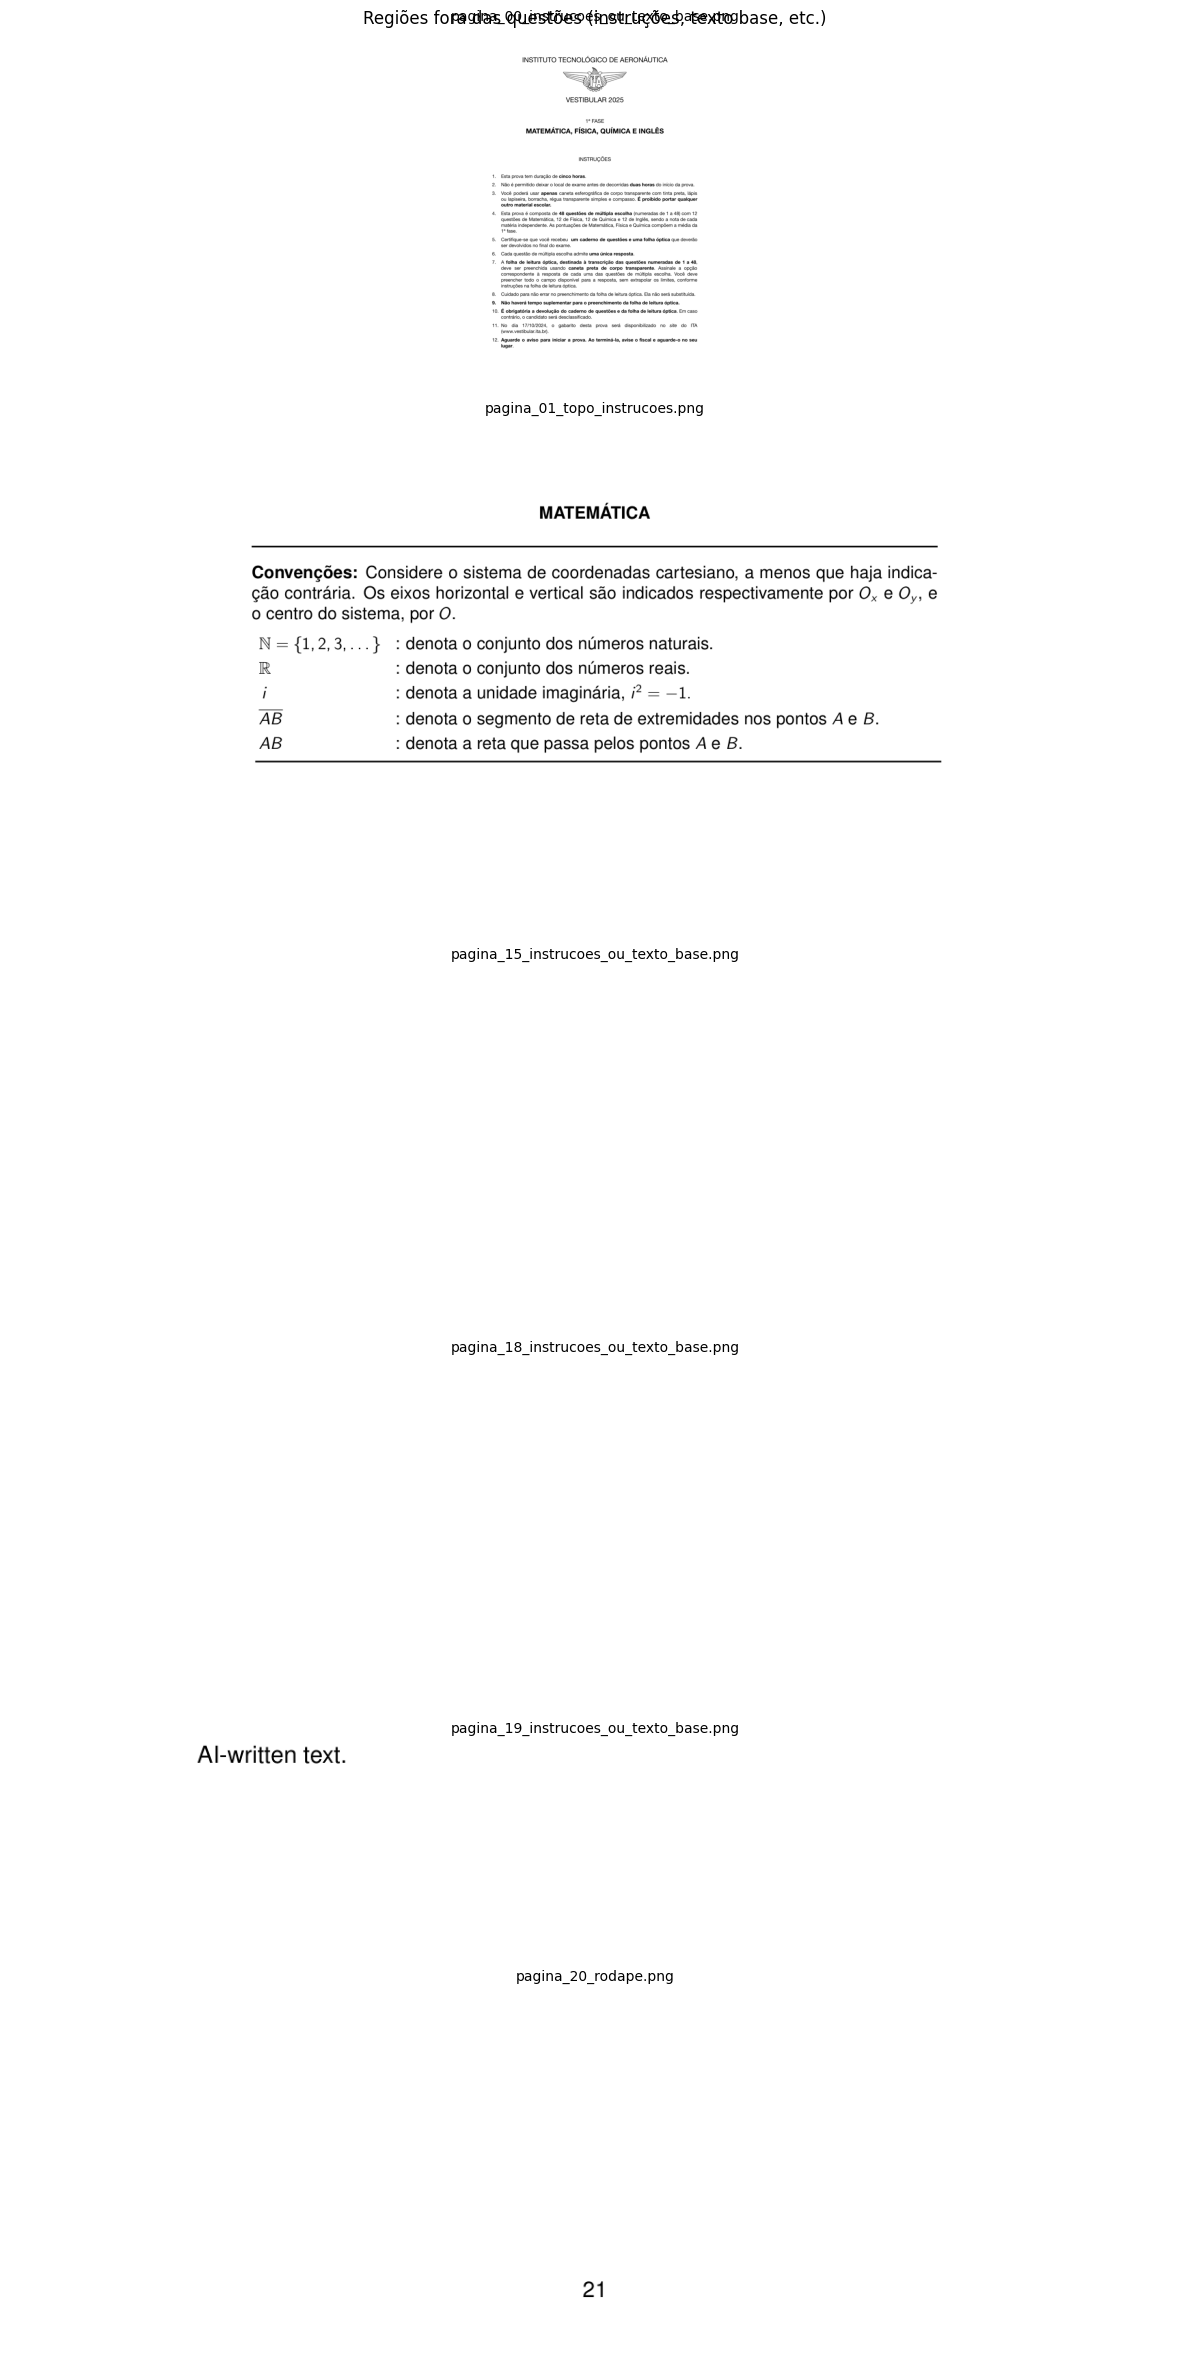

In [74]:
# Visualizar no notebook: imagens do que está fora das questões (instruções, texto base)
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

figuras_fora = sorted(OUT_DIR_FORA.glob("*.png"))[:6]
n = len(figuras_fora)
if n:
  fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))
  if n == 1:
    axes = [axes]
  for ax, path in zip(axes, figuras_fora):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(path.name, fontsize=10)
    ax.axis("off")
  plt.suptitle("Regiões fora das questões (instruções, texto base, etc.)", fontsize=12)
  plt.tight_layout()
  plt.show()
else:
  print("Nenhuma região fora das questões encontrada.")

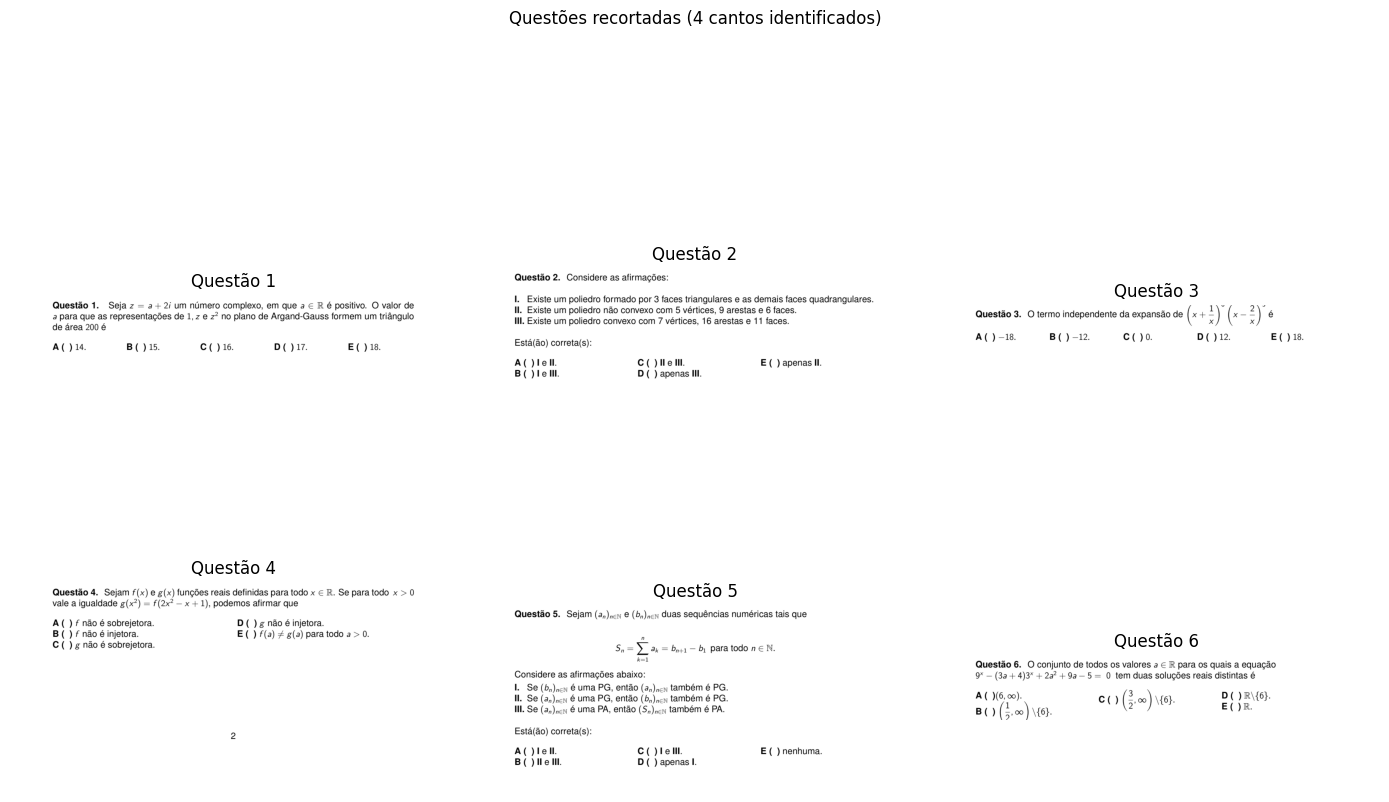

In [75]:
# Exibir uma figura resumo: grid com as primeiras questões separadas
import matplotlib.pyplot as plt
from matplotlib import image as mpimg


def path_questao(num, part=0):
  p = OUT_DIR / f"questao_{num:02d}.png"
  if p.exists():
    return p
  return OUT_DIR / f"questao_{num:02d}_p{part + 1}.png"


N_SHOW = 6
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
for idx, num in enumerate(list(question_rects.keys())[:N_SHOW]):
  path = path_questao(num)
  if path.exists():
    img = mpimg.imread(path)
    axes[idx].imshow(img)
  axes[idx].set_title(f"Questão {num}")
  axes[idx].axis("off")
plt.suptitle("Questões recortadas (4 cantos identificados)", fontsize=12)
plt.tight_layout()
plt.show()

In [76]:
# Extrair texto separado: dentro da questão e fora (na mesma página), sem juntar
# - texto_dentro: só o que está dentro do recorte da questão
# - texto_fora: texto da(s) página(s) da questão que está fora do recorte (instruções, constantes, etc.)
#   Não inclui trechos que contenham o padrão "Questão N" / "Quest˜ao N" (outras questões).

# Padrão para detectar início de outra questão (não pode aparecer no texto_fora)
_QUESTAO_PATTERN = re.compile(r"Quest(ão|\u02dcao|ao)\s+\d+", re.IGNORECASE)


def _bloco_contem_questao(text):
  """True se o texto contém 'Questão N' ou variantes (Quest˜ao, Questao)."""
  return bool(_QUESTAO_PATTERN.search(text))


def get_text_in_rect(page, rect):
  """Texto contido no retângulo."""
  return page.get_text(clip=rect, sort=True).strip()


def extract_question_texts(doc, question_rects):
  """Retorna (texto_dentro_por_questao, texto_fora_por_questao)."""
  dentro = {}
  fora = {}
  for num, clips in question_rects.items():
    textos_dentro = []
    for page_no, clip in clips:
      page = doc[page_no]
      textos_dentro.append(get_text_in_rect(page, clip))
    dentro[num] = "\n\n".join(t for t in textos_dentro if t)
    # Texto fora: blocos fora do clip que NÃO contêm o padrão "Questão N"
    textos_fora_por_pagina = []
    for page_no, clip in clips:
      page = doc[page_no]
      blocks = page.get_text("blocks", clip=page.rect)
      outside = []
      for b in blocks:
        if len(b) >= 5:
          x0, y0, x1, y1, text = b[0], b[1], b[2], b[3], b[4]
          if not text.strip():
            continue
          if _bloco_contem_questao(text):
            continue  # não incluir outras questões no "fora"
          block_rect = pymupdf.Rect(x0, y0, x1, y1)
          if not clip.intersects(block_rect):
            outside.append(text.strip())
      if outside:
        textos_fora_por_pagina.append(f"[Página {page_no + 1}]\n" + "\n".join(outside))
    fora[num] = "\n---\n".join(textos_fora_por_pagina) if textos_fora_por_pagina else ""
  return dentro, fora


texto_dentro, texto_fora = extract_question_texts(doc, question_rects)
print("Exemplo Questão 1 - DENTRO do recorte:")
print(texto_dentro.get(1, "")[:500])
print("\n...")
if texto_fora.get(1):
  print("\nExemplo Questão 1 - FORA do recorte (na mesma página):")
  print(texto_fora.get(1)[:400])
else:
  print("\nQuestão 1 não tem texto fora do recorte.")

Exemplo Questão 1 - DENTRO do recorte:
Questão 1.  Seja z = a + 2i um número complexo, em que a ∈R é positivo. O valor de
a para que as representações de 1; z e z2 no plano de Argand-Gauss formem um triângulo
de área 200 é

A (  ) 14.      B (  ) 15.      C (  ) 16.      D (  ) 17.       E (  ) 18.

...

Exemplo Questão 1 - FORA do recorte (na mesma página):
[Página 2]
MATEMÁTICA
Convenções: Considere o sistema de coordenadas cartesiano, a menos que haja indica-
ção contrária. Os eixos horizontal e vertical são indicados respectivamente por Ox e Oy, e
o centro do sistema, por O.
N = {1; 2; 3; : : : }
: denota o conjunto dos números naturais.
R
: denota o conjunto dos números reais.
i
: denota a unidade imaginária, i2 = −1:
AB
: denota o segmento de re


In [77]:
# Salvar textos em arquivos: um por questão (dentro) e um por questão (fora), para você ver os dois
if "BASE_DATA" not in dir():
  _here = Path(".").resolve()
  BASE_DATA = (
    _here.parent / "data" / "vestibular"
    if _here.name == "notebooks"
    else _here / "data" / "vestibular"
  )
TEXTOS_DIR = BASE_DATA / "figs" / "textos_questoes"
TEXTOS_DIR.mkdir(parents=True, exist_ok=True)

for num in texto_dentro:
  (TEXTOS_DIR / f"questao_{num:02d}_dentro.txt").write_text(
    texto_dentro[num], encoding="utf-8"
  )
  if texto_fora.get(num):
    (TEXTOS_DIR / f"questao_{num:02d}_fora.txt").write_text(
      texto_fora[num], encoding="utf-8"
    )

print(f"Textos salvos em {TEXTOS_DIR.absolute()}")
print("  - questao_XX_dentro.txt = texto só dentro do recorte da questão")
print(
  "  - questao_XX_fora.txt   = texto na mesma página, fora do recorte (quando houver)"
)

Textos salvos em /Users/matheusmota/src/github/personal/ita-api/data/vestibular/figs/textos_questoes
  - questao_XX_dentro.txt = texto só dentro do recorte da questão
  - questao_XX_fora.txt   = texto na mesma página, fora do recorte (quando houver)


In [78]:
# Visualizar no notebook: uma questão com texto DENTRO e texto FORA separados
def mostrar_questao_texto(num):
  print("=" * 60)
  print(f"QUESTÃO {num} — TEXTO DENTRO DO RECORTE")
  print("=" * 60)
  print(texto_dentro.get(num, "(vazio)"))
  print()
  if texto_fora.get(num):
    print("=" * 60)
    print(f"QUESTÃO {num} — TEXTO FORA DO RECORTE (mesma página)")
    print("=" * 60)
    print(texto_fora[num])
  else:
    print(f"Questão {num}: não há texto fora do recorte nesta(s) página(s).")


# Mostrar questões 1 e 2 como exemplo
mostrar_questao_texto(1)
print("\n")
mostrar_questao_texto(2)

QUESTÃO 1 — TEXTO DENTRO DO RECORTE
Questão 1.  Seja z = a + 2i um número complexo, em que a ∈R é positivo. O valor de
a para que as representações de 1; z e z2 no plano de Argand-Gauss formem um triângulo
de área 200 é

A (  ) 14.      B (  ) 15.      C (  ) 16.      D (  ) 17.       E (  ) 18.

QUESTÃO 1 — TEXTO FORA DO RECORTE (mesma página)
[Página 2]
MATEMÁTICA
Convenções: Considere o sistema de coordenadas cartesiano, a menos que haja indica-
ção contrária. Os eixos horizontal e vertical são indicados respectivamente por Ox e Oy, e
o centro do sistema, por O.
N = {1; 2; 3; : : : }
: denota o conjunto dos números naturais.
R
: denota o conjunto dos números reais.
i
: denota a unidade imaginária, i2 = −1:
AB
: denota o segmento de reta de extremidades nos pontos A e B.
AB
: denota a reta que passa pelos pontos A e B.
I.
Existe um poliedro formado por 3 faces triangulares e as demais faces quadrangulares.
II. Existe um poliedro não convexo com 5 vértices, 9 arestas e 6 faces.
III. E